# OBJECTIVE


Objective:

1. Take the 6A Code, and show how it can be integrated with gradCAM. As proof of integration, test 4 images (remember the image ids or names) from your network and show the visualization.
2. Train your 6A model again, but this time add CutOut. Show the same 4 images again with gradCAM's result.


For this assignment, we will use CIFAR10 Dataset.

* The CIFAR10 dataset consists of 60,000 32x32 images in different classes. The 10 different classes represents cars, birds, cats, deer, dogs, frogs, horses, ships, trucks and aeroplanes. There are 6,000 images of each class.










# Importing Keras Libraries and Modules

In [1]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
import keras.models
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils

Using TensorFlow backend.


# Importing Cifar10 dataset

In [2]:
# Importing Cifar10 dataset
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 3s 0us/step


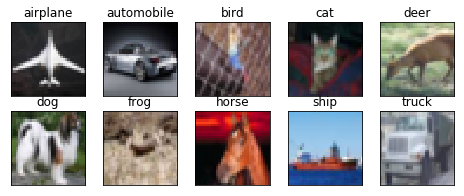

In [3]:
# Ploting each class from cifar10 dataset
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [0]:
# Function to plot model history
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
#Function to define accuracy
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
test_features_grad = test_features

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

In [8]:
# Define the Model
from keras import regularizers

model = Sequential()
model.add(Conv2D(32, (3, 3), border_mode='same',kernel_regularizer=regularizers.l2(0.0001), input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Activation('relu')) #32


model.add(Conv2D(64, (3, 3), border_mode='same', kernel_regularizer=regularizers.l2(0.0001)))
model.add(BatchNormalization())
model.add(Activation('relu')) #32


model.add(MaxPooling2D(pool_size=(2, 2))) #16
model.add(Dropout(0.2))
model.add(Conv2D(32, 1, 1))


model.add(Conv2D(64, 3, 3,border_mode='same', kernel_regularizer=regularizers.l2(0.0001)))
model.add(BatchNormalization())
model.add(Activation('relu')) #16


model.add(Conv2D(128, 3, 3, border_mode='same', kernel_regularizer=regularizers.l2(0.0001)))
model.add(BatchNormalization())
model.add(Activation('relu')) #16


model.add(MaxPooling2D(pool_size=(2, 2))) #8
model.add(Dropout(0.3))
model.add(Conv2D(32, 1, 1))


model.add(Conv2D(128, (3, 3), border_mode='same', kernel_regularizer=regularizers.l2(0.0001)))
model.add(BatchNormalization())
model.add(Activation('relu')) #8


model.add(Conv2D(256, (3, 3), border_mode='same', kernel_regularizer=regularizers.l2(0.0001)))
model.add(BatchNormalization())
model.add(Activation('relu')) #8


model.add(MaxPooling2D(pool_size=(2, 2))) #4
model.add(Dropout(0.5))
model.add(Conv2D(10, 1, 1))

model.add(AveragePooling2D(pool_size = (4,4)))
model.add(Flatten())


model.add(Activation('softmax'))


W0628 21:56:41.861963 139727160813440 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), kernel_regularizer=<keras.reg..., input_shape=(32, 32, 3..., padding="same")`
  after removing the cwd from sys.path.
W0628 21:56:41.898912 139727160813440 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0628 21:56:41.904476 139727160813440 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0628 21:56:41.949151 1

In [9]:
from google.colab import drive
drive.mount('../content/drive/', force_remount=True)

import os
os. listdir('../content/drive/My Drive/EVA')

checkpointer = ModelCheckpoint(filepath='../content/drive/My Drive/EVA/assignment9_before.h5', monitor='val_acc', mode='auto', verbose = 1, save_best_only=True)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at ../content/drive/


In [10]:
lr_reducer = ReduceLROnPlateau(monitor='val_acc',factor=0.8, cooldown=0, patience=5, min_lr=0.5e-9,verbose = 1)


# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

W0628 21:57:14.961506 139727160813440 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0628 21:57:14.992657 139727160813440 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
__________

# Model  without Cutout

Epoch 1/100
391/390 [==============================] - 10s 27ms/step - loss: 0.2916 - acc: 0.9050 - val_loss: 0.3877 - val_acc: 0.8839

Epoch 00001: val_acc improved from -inf to 0.88386, saving model to ../content/drive/My Drive/EVA/assignment9_before.h5
Epoch 2/100
391/390 [==============================] - 6s 16ms/step - loss: 0.2438 - acc: 0.9185 - val_loss: 0.2686 - val_acc: 0.9135

Epoch 00002: val_acc improved from 0.88386 to 0.91355, saving model to ../content/drive/My Drive/EVA/assignment9_before.h5
Epoch 3/100
391/390 [==============================] - 6s 16ms/step - loss: 0.2192 - acc: 0.9274 - val_loss: 0.2048 - val_acc: 0.9305

Epoch 00003: val_acc improved from 0.91355 to 0.93053, saving model to ../content/drive/My Drive/EVA/assignment9_before.h5
Epoch 4/100
391/390 [==============================] - 6s 16ms/step - loss: 0.2044 - acc: 0.9325 - val_loss: 0.2763 - val_acc: 0.9077

Epoch 00004: val_acc did not improve from 0.93053
Epoch 5/100
391/390 [======================

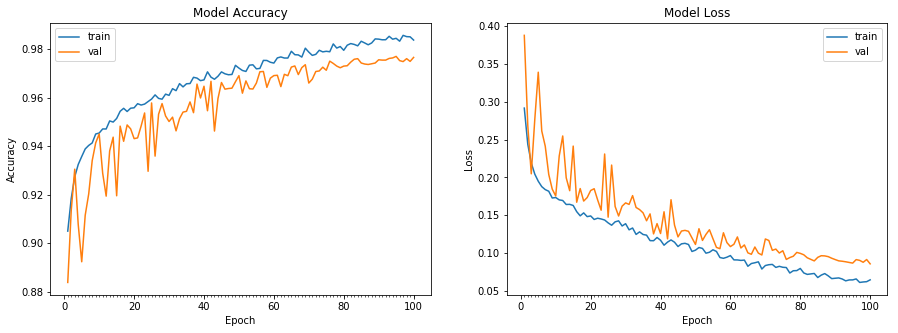

Accuracy on test data is: 87.84


In [11]:
datagen = ImageDataGenerator(zoom_range=0.0,horizontal_flip=False)

start = time.time()
batch_size = 128
model_info = model.fit_generator(datagen.flow(train_features, train_labels),
                                 steps_per_epoch = train_features.shape[0]/batch_size, epochs = 100, 
                                 validation_data = (test_features, test_labels), verbose=1,callbacks=[lr_reducer, checkpointer])
end = time.time()

print ("Model took %0.2f seconds to train" %(end - start))


# plot model history
plot_model_history(model_info)


# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

In [12]:
model = keras.models.load_model('../content/drive/My Drive/EVA/assignment9_before.h5')
score = model.evaluate(test_features, test_labels, batch_size=128)
print (score[1])

10000/10000 [==============================] - 1s 121us/step
0.9770000050544739


# Grad CAM Integration

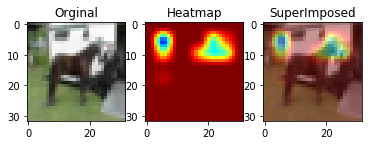

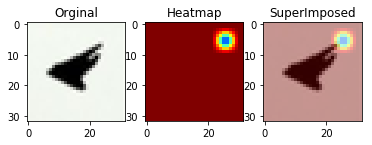

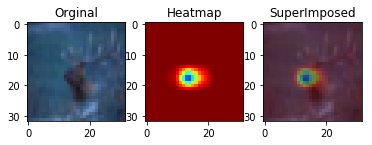

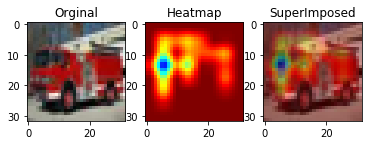

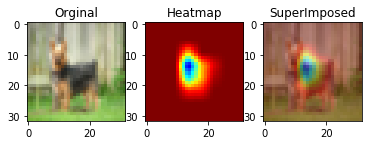

In [14]:
import keras.backend as K
import numpy as np
import cv2
from keras.preprocessing import image


def gradcam():

    c = 20
    for j in range(20,25):
      
      img = test_features_grad[j]
      img_t = image.img_to_array(img)
      img_t = np.expand_dims(img_t, axis=0)
      img_t = img_t / img_t.mean()  
  
      preds = model.predict(img_t)
      class_idx = np.argmax(preds[0])
      class_output = model.output[:, class_idx]
      last_conv_layer = model.get_layer("conv2d_8")  
  
      grads = K.gradients(class_output, last_conv_layer.output)[0]
      pooled_grads = K.mean(grads, axis=(0, 1, 2))

      iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
      pooled_grads_value, conv_layer_output_value = iterate([img_t])
  
      for i in range(64):
          conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
      heatmap = np.mean(conv_layer_output_value, axis=-1)
      heatmap = np.maximum(heatmap, 0)
      heatmap /= np.max(heatmap)
  
      heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
      heatmap = np.uint8(255 * heatmap)
      heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  
      superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
      
      plt.subplot(1, 3, 1)
      plt.imshow(test_features[c])
      plt.title('Orginal')
      
      plt.subplot(1, 3, 2)
      plt.imshow(heatmap)
      plt.title('Heatmap')
      
      
      plt.subplot(1, 3, 3)
      plt.imshow(superimposed_img)
      plt.title('SuperImposed')
      c += 1
      plt.show()
      
      
gradcam()

In [15]:
# Define the Model
from keras import regularizers

model = Sequential()
model.add(Conv2D(32, (3, 3), border_mode='same',kernel_regularizer=regularizers.l2(0.0001), input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Activation('relu')) #32


model.add(Conv2D(64, (3, 3), border_mode='same', kernel_regularizer=regularizers.l2(0.0001)))
model.add(BatchNormalization())
model.add(Activation('relu')) #32


model.add(MaxPooling2D(pool_size=(2, 2))) #16
model.add(Dropout(0.2))
model.add(Conv2D(32, 1, 1))


model.add(Conv2D(64, 3, 3,border_mode='same', kernel_regularizer=regularizers.l2(0.0001)))
model.add(BatchNormalization())
model.add(Activation('relu')) #16


model.add(Conv2D(128, 3, 3, border_mode='same', kernel_regularizer=regularizers.l2(0.0001)))
model.add(BatchNormalization())
model.add(Activation('relu')) #16


model.add(MaxPooling2D(pool_size=(2, 2))) #8
model.add(Dropout(0.3))
model.add(Conv2D(32, 1, 1))


model.add(Conv2D(128, (3, 3), border_mode='same', kernel_regularizer=regularizers.l2(0.0001)))
model.add(BatchNormalization())
model.add(Activation('relu')) #8


model.add(Conv2D(256, (3, 3), border_mode='same', kernel_regularizer=regularizers.l2(0.0001)))
model.add(BatchNormalization())
model.add(Activation('relu')) #8


model.add(MaxPooling2D(pool_size=(2, 2))) #4
model.add(Dropout(0.5))
model.add(Conv2D(10, 1, 1))

model.add(AveragePooling2D(pool_size = (4,4)))
model.add(Flatten())


model.add(Activation('softmax'))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), kernel_regularizer=<keras.reg..., input_shape=(32, 32, 3..., padding="same")`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1))`
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_regularizer=<keras.reg..., padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), ker

In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_8 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
activation_9 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 64)        0         
__________

In [0]:
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau

checkpointer1 = ModelCheckpoint(filepath='../content/drive/My Drive/EVA//assignment9_after.h5', monitor='val_acc', mode='auto', verbose = 1, save_best_only=True)
lr_reducer1 = ReduceLROnPlateau(monitor='val_acc',factor=0.8, cooldown=0, patience=5, min_lr=0.5e-9,verbose = 1)



# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

# Model  with CutOut

Epoch 1/100
391/390 [==============================] - 9s 23ms/step - loss: 0.3010 - acc: 0.9024 - val_loss: 0.3174 - val_acc: 0.8965

Epoch 00001: val_acc improved from -inf to 0.89655, saving model to ../content/drive/My Drive/EVA//assignment9_after.h5
Epoch 2/100
391/390 [==============================] - 7s 17ms/step - loss: 0.2603 - acc: 0.9126 - val_loss: 0.3390 - val_acc: 0.9001

Epoch 00002: val_acc improved from 0.89655 to 0.90008, saving model to ../content/drive/My Drive/EVA//assignment9_after.h5
Epoch 3/100
391/390 [==============================] - 7s 17ms/step - loss: 0.2352 - acc: 0.9199 - val_loss: 0.2983 - val_acc: 0.8990

Epoch 00003: val_acc did not improve from 0.90008
Epoch 4/100
391/390 [==============================] - 7s 17ms/step - loss: 0.2208 - acc: 0.9255 - val_loss: 0.2836 - val_acc: 0.9045

Epoch 00004: val_acc improved from 0.90008 to 0.90449, saving model to ../content/drive/My Drive/EVA//assignment9_after.h5
Epoch 5/100
391/390 [=======================

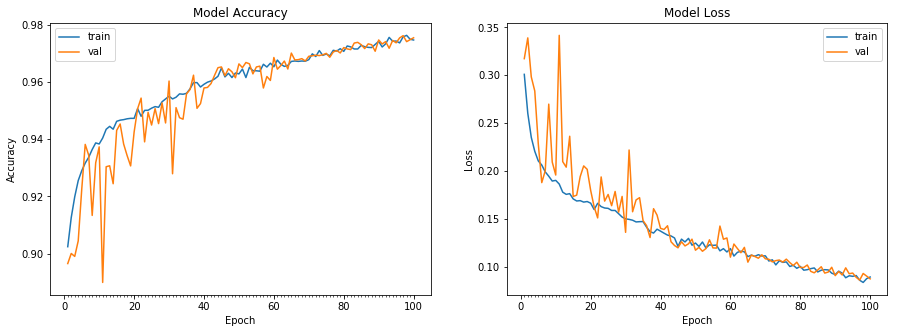

Accuracy on test data is: 87.18


In [19]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False,
                             preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=True))
start = time.time()
batch_size = 128
model_info = model.fit_generator(datagen.flow(train_features, train_labels),
                                 steps_per_epoch = train_features.shape[0]/batch_size, epochs = 100, 
                                 validation_data = (test_features, test_labels), verbose=1,callbacks=[lr_reducer1, checkpointer1])
end = time.time()

print ("Model took %0.2f seconds to train" %(end - start))


# plot model history
plot_model_history(model_info)


# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))


In [20]:
model=keras.models.load_model('../content/drive/My Drive/EVA/assignment9_after.h5')
score = model.evaluate(test_features, test_labels, batch_size=128)
print (score[1])

10000/10000 [==============================] - 1s 133us/step
0.976220004749298


# Model Grad CAM results: with CutOut


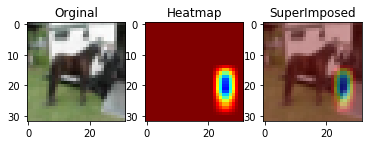

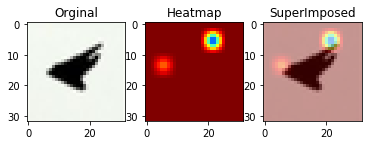

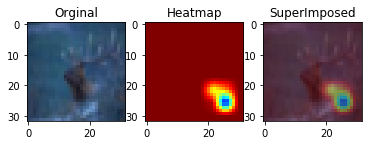

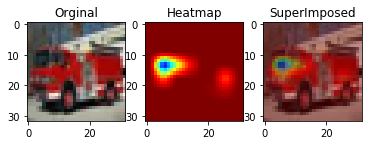

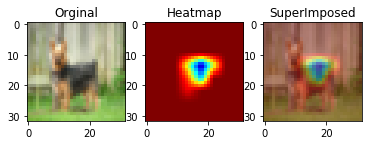

In [21]:
import keras.backend as K
import numpy as np
import cv2
from keras.preprocessing import image


def gradcam_cutoff():


    c = 20
    for j in range(20,25):
      
      img = test_features_grad[j]
      img_t = image.img_to_array(img)
      img_t = np.expand_dims(img_t, axis=0)
      img_t = img_t / img_t.mean()  
  
      preds = model.predict(img_t)
      class_idx = np.argmax(preds[0])
      class_output = model.output[:, class_idx]
      last_conv_layer = model.get_layer("conv2d_17")  
  
      grads = K.gradients(class_output, last_conv_layer.output)[0]
      pooled_grads = K.mean(grads, axis=(0, 1, 2))

      iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
      pooled_grads_value, conv_layer_output_value = iterate([img_t])
  
      for i in range(64):
          conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
      heatmap = np.mean(conv_layer_output_value, axis=-1)
      heatmap = np.maximum(heatmap, 0)
      heatmap /= np.max(heatmap)
  
      heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
      heatmap = np.uint8(255 * heatmap)
      heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  
      superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
      
      plt.subplot(1, 3, 1)
      plt.imshow(test_features[c])
      plt.title('Orginal')
      
      plt.subplot(1, 3, 2)
      plt.imshow(heatmap)
      plt.title('Heatmap')
      
      
      plt.subplot(1, 3, 3)
      plt.imshow(superimposed_img)
      plt.title('SuperImposed')
      c += 1
      plt.show()
      
      
gradcam_cutoff()